In [1]:
import warnings 
warnings.filterwarnings("ignore")

In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.stats
from matplotlib import container

In [3]:
plt.rcParams["font.family"] = "times" # "helvetica"
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'


In [4]:
summary_df = pd.read_csv("aggregate_summary_all.csv", index_col=0)
molecules = summary_df["molecule"]
molecule_set = set(molecules)
group_key = "molecule"


# Data cleaning and intial set up

In [5]:
summary_df = summary_df[summary_df["pressure"] != 3000]

In [6]:
from pprint import pprint

def data_cleaning(molecule_set):
    """Make sure properties of all molecule in the provided molecule_set has been calculated."""
    for molecule in molecule_set:
        try:
            mol_group = summary_df.groupby(group_key)
            mol_df = mol_group.get_group(molecule)
        except KeyError:
            print(f"skipping: {molecule}, no data available.")
            continue
        mol_df["statepoint"] = (
            summary_df["temperature"].map(str)
            + "K, "
            + summary_df["pressure"].map(str)
            + "kPa, "
            + summary_df["ensemble"]
        )
        sp_set = set(mol_df["statepoint"])
        goods = list()
        bads = list()
        for engine in mol_df["engine"].unique():
            found_sp = mol_df[mol_df["engine"] == engine].index.tolist()
            if len(found_sp) == len(set(mol_df["statepoint"])):
                goods.append((engine, found_sp))
            else:
                mol_df.drop(axis=0, labels=found_sp, inplace=True)
                bads.append((engine, found_sp))

        if goods:
            print(f"\tPassed: {[good[0] for good in goods]}")
        if bads:
            print(f"\tFailed: {[bad[0] for bad in bads]}")
data_cleaning(molecule_set)

	Passed: ['gromacs', 'mcccs', 'lammps-VU', 'cassandra', 'gomc', 'hoomd']
	Passed: ['gomc', 'lammps-VU', 'hoomd', 'cassandra', 'mcccs', 'gromacs']
	Passed: ['gomc', 'gromacs', 'hoomd', 'mcccs', 'cassandra']
	Passed: ['hoomd', 'cassandra', 'gromacs', 'gomc', 'mcccs', 'lammps-VU']
	Passed: ['lammps-VU', 'hoomd', 'gomc', 'cassandra', 'mcccs', 'gromacs']
	Passed: ['gromacs', 'hoomd', 'lammps-VU']


# Analysis Methods

In [7]:
def mean_confidence_interval(m,se, confidence=0.95):  
    se = np.array(se)
    n = 16
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

# Plotting Helper and Styling

In [8]:
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

In [9]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)


In [10]:
all_engine_molecule = ("methaneUA", "ethanolAA", "waterSPCE",)
pentane_fixed = ("pentaneUA-constrain_bonds",)
rigid_benzene = ("benzeneUA",) 

md_only = ["lammps-VU", "gromacs", "hoomd",]
mc_only = ["mcccs", "gomc", "cassandra"]

all_engine_orders = (
    "lammps-VU", 
    "gromacs", 
    "hoomd", 
    "mcccs", 
    "gomc", 
    "cassandra")
pentane_fixed_orders = (
    "gromacs", 
    "hoomd", 
    "mcccs", 
    "gomc", 
    "cassandra",
)
rigid_benzene_orders = (
    "lammps-VU", 
    "hoomd", 
    "mcccs", 
    "gomc",
    "cassandra",
)

#ylims
ylims = {
    "methaneUA": (375.5, 376.1), 
    "ethanolAA": (750, 830), 
    "waterSPCE": (982.5, 1010),
    "benzeneUA": (696.5, 700), 
    "pentaneUA-constrain_bonds": (539.5, 543), 
}


# Colors
symbols = {}
symbols["cassandra"] = "o"
symbols[ "mcccs"] = "^"
symbols["gomc"] = "s"
symbols["gromacs"] = "p" 
symbols[ "hoomd"] = "v" 
symbols[ "lammps-VU"] = "D"
#symbols[ "LAMMPS-UD"] = ">"

colors = {}
colors["cassandra"] = "#045275" #(23/256, 109/256, 156/256)
colors["mcccs"] = "#089099" #(194/256, 135/256, 32/256)
colors["gomc"] = "#7CCBA2" #(21/256, 138/256, 106/256)
colors["gromacs"] = "#F0746E" #(186/256, 97/256, 26/256)
colors["hoomd"] = "#DC3977" #(193/256, 130/256, 181/256)
colors["lammps-VU"] = "#7C1D6F" #(188/256, 146/256, 110/256)

# colors_dict = {all_engine_molecule: all_engine_colors, 
#                pentane_fixed: pentane_fixed_colors,
#                pentane_flexible: pentane_flexible_colors}

pretty_names = {
    "cassandra": "Cassandra (MC)",
    "mcccs": "MCCCS-MN (MC)", 
    "gomc": "GOMC (MC)",
    "gromacs": "GROMACS (MD)", 
    "hoomd": "HOOMD-blue (MD)", 
    "lammps-VU": "LAMMPS (MD)",
}

fill_styles = {
    "cassandra": "none", 
    "mcccs": "none", 
    "gomc": "none", 
    "gromacs": "full", 
    "hoomd": "full",
    "lammps-VU": "full",
}

In [11]:
def create_stacked_density_deviation_plots(molecules, engines, figsize):
    for molecule in molecules:
        print(molecule)
        #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(2, hspace=0)
        ax = gs.subplots(sharex=True, sharey=False)
        
        try:
            mol_group = summary_df.groupby(group_key)
            mol_df = mol_group.get_group(molecule)
        except KeyError:
            print(f"skipping: {molecule}, no data available.")
            continue
        mol_df["statepoint"] = (
            summary_df["temperature"].map(str)
            + " K"
            # + round(summary_df["pressure"] / 101.325, 2).map(str)
            # + " atm"
            )
            
        statepoints = sorted(set(mol_df["statepoint"]))
        statepoints_overall_means = list()

        xticks = list()
        sps_positions = list()
        for n_statepoint, statepoint in enumerate(statepoints):
            # print(statepoint)
            densities = list()
            stds = list()
            sems = list()
            for engine in engines:
                shortlisted = mol_df[
                    (mol_df["engine"]==engine)
                  & (mol_df["statepoint"]==statepoint)]
                # densities.append(shortlisted["density-avg"])
                # stds.append(shortlisted["density-std"])
                # sems.append(shortlisted["density-sem"])
                densities.append(shortlisted["density-avg"]*1000)
                stds.append(shortlisted["density-std"]*1000)
                sems.append(shortlisted["density-sem"]*1000)
            overall_mean = np.mean(densities)
            statepoints_overall_means.append(overall_mean)

            confidence_interval = mean_confidence_interval(densities, np.array(sems), confidence=0.95)
            percentage_delta_density = (densities-overall_mean) * 100 / overall_mean
            percentage_sem_density = 100 * np.array(sems) / overall_mean
            percentage_ci_density = 100 * np.array(confidence_interval) / overall_mean

            ind = list()
            sp_position = list()
            space_scaling = 2
            for i, engine in enumerate(engines): 
                print(engine, float(densities[i]), float(confidence_interval[i]))
                print(float(percentage_delta_density[i]), float(percentage_ci_density[i]))
                ind.append(i)
                spacing = space_scaling*n_statepoint + space_scaling/10*i
                sp_position.append(spacing)
                ax[0].errorbar(
                     spacing, 
                     densities[i],  
                     marker=symbols[engine],
                     yerr=confidence_interval[i],
                     color=colors[engine], 
                     fillstyle=fill_styles[engine],
                     ls='',
                     label=engine,
                    )
                ax[1].errorbar(
                     spacing, 
                     percentage_delta_density[i],  
                     marker=symbols[engine],
                     yerr=percentage_ci_density[i],
                     color=colors[engine], 
                     fillstyle=fill_styles[engine],
                     ls='',
                     label=engine,
                    )
            sps_positions.append(np.mean(sp_position))
            xticks.append(statepoint+r'$\rho_{\mathrm{ave}}$'+r'$ = {:.3f}$'.format(overall_mean))
        
        ax[1].axhline(y = 0, color = 'black', alpha=0.5, linestyle = '--')

        #ax[1].set_xlabel("State point")
        ax[1].set_ylabel(r"${100\times\Delta\rho}/{\rho}$")
        ax[0].set_ylabel(r"$\rho$ [$\mathrm{{kg}/{m^3}}$]")

        ax[0].tick_params(axis='y')
        #plt.title(f"{molecule}")
        props = dict(boxstyle='round', facecolor='none',alpha=1, ec = 'grey')
        #string+='{:.5f}'.format(overall_mean)

        ax[0].set_xticks([pos for pos in sps_positions])    
        if len(statepoints) != 1:
            ax[0].set_xticklabels([statepoint for statepoint in statepoints])
            
            ax[0].set_xlim(sps_positions[0]-1, sps_positions[-1]+1)
            ax[1].set_xlim(sps_positions[0]-1, sps_positions[-1]+1)
        else:
            plt.xticks([])


        # Handle ylim 
        ax[0].set_ylim(ylims[molecule][0], ylims[molecule][1],) 
        
        low, high = ax[1].get_ylim()
        bound = max(abs(low), abs(high))
        #ax1.set_ylim(-bound*1.1, bound*1.1) 
        ax[1].set_ylim(round(-bound*1.1, 1), round(bound*1.1, 1))
        if molecule == "ethanolAA": 
            ax[1].set_ylim(-0.6, 0.6)
        

        # get handles
        #wrap_labels(ax, 10)
        handles, labels = ax[1].get_legend_handles_labels()
        
        #Sorting handles and labels: 
        labels_handles = dict()
        for handle, label in zip(handles, labels):
            labels_handles[label] = handle
        sorted_handles = [labels_handles[engine] for engine in engines]
        sorted_labels = [pretty_names[engine] for engine in engines]
        
        
        ax[0].legend(
                   sorted_handles, 
                   sorted_labels,
                   facecolor='white', 
                   loc="best", # 'upper center',
                   prop={'size': 14},
                   ncol=2
        )
        plt.subplots_adjust(bottom=0)
        plt.tight_layout()
        
        
        for i in range(2):
            ax[i].tick_params(which='both', width=1)
            ax[i].tick_params(which="major", length=8, axis="y", bottom=False)
            ax[i].tick_params(which="minor", length=4, axis="y", bottom=False)
            ax[i].minorticks_on()
            ax[i].xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
            ax[i].yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
            
        
        ax[1].tick_params(
            axis='x',          # changes apply to the x-axis
            which='minor',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            ) # labels along the bottom edge are off
        ax[1].tick_params(
            axis='x',          # changes apply to the x-axis
            which='major',      # both major and minor ticks are affected
            length=8
            ) # labels along the bottom edge are off
        plt.savefig(f"figures/{molecule}_stacked_deviation_density.pdf", 
                    dpi=500, 
                    bbox_inches='tight')
        plt.show()
        plt.close()

methaneUA
lammps-VU 375.96119089536415 0.0236366895205292
0.02755220642889861 0.00628873472118539
gromacs 375.95733276707386 0.029192396657029118
0.026525719817190183 0.007766876080181516
hoomd 375.9553573225096 0.01860300418216355
0.026000136621189426 0.00494948153450677
mcccs 375.7593605773164 0.09789414111119897
-0.026146401736703608 0.026045537539084104
gomc 375.78899933770833 0.06229788295392793
-0.018260766931209982 0.016574861689004353
cassandra 375.72356204531246 0.09335548676886654
-0.03567089419936464 0.02483799140089522


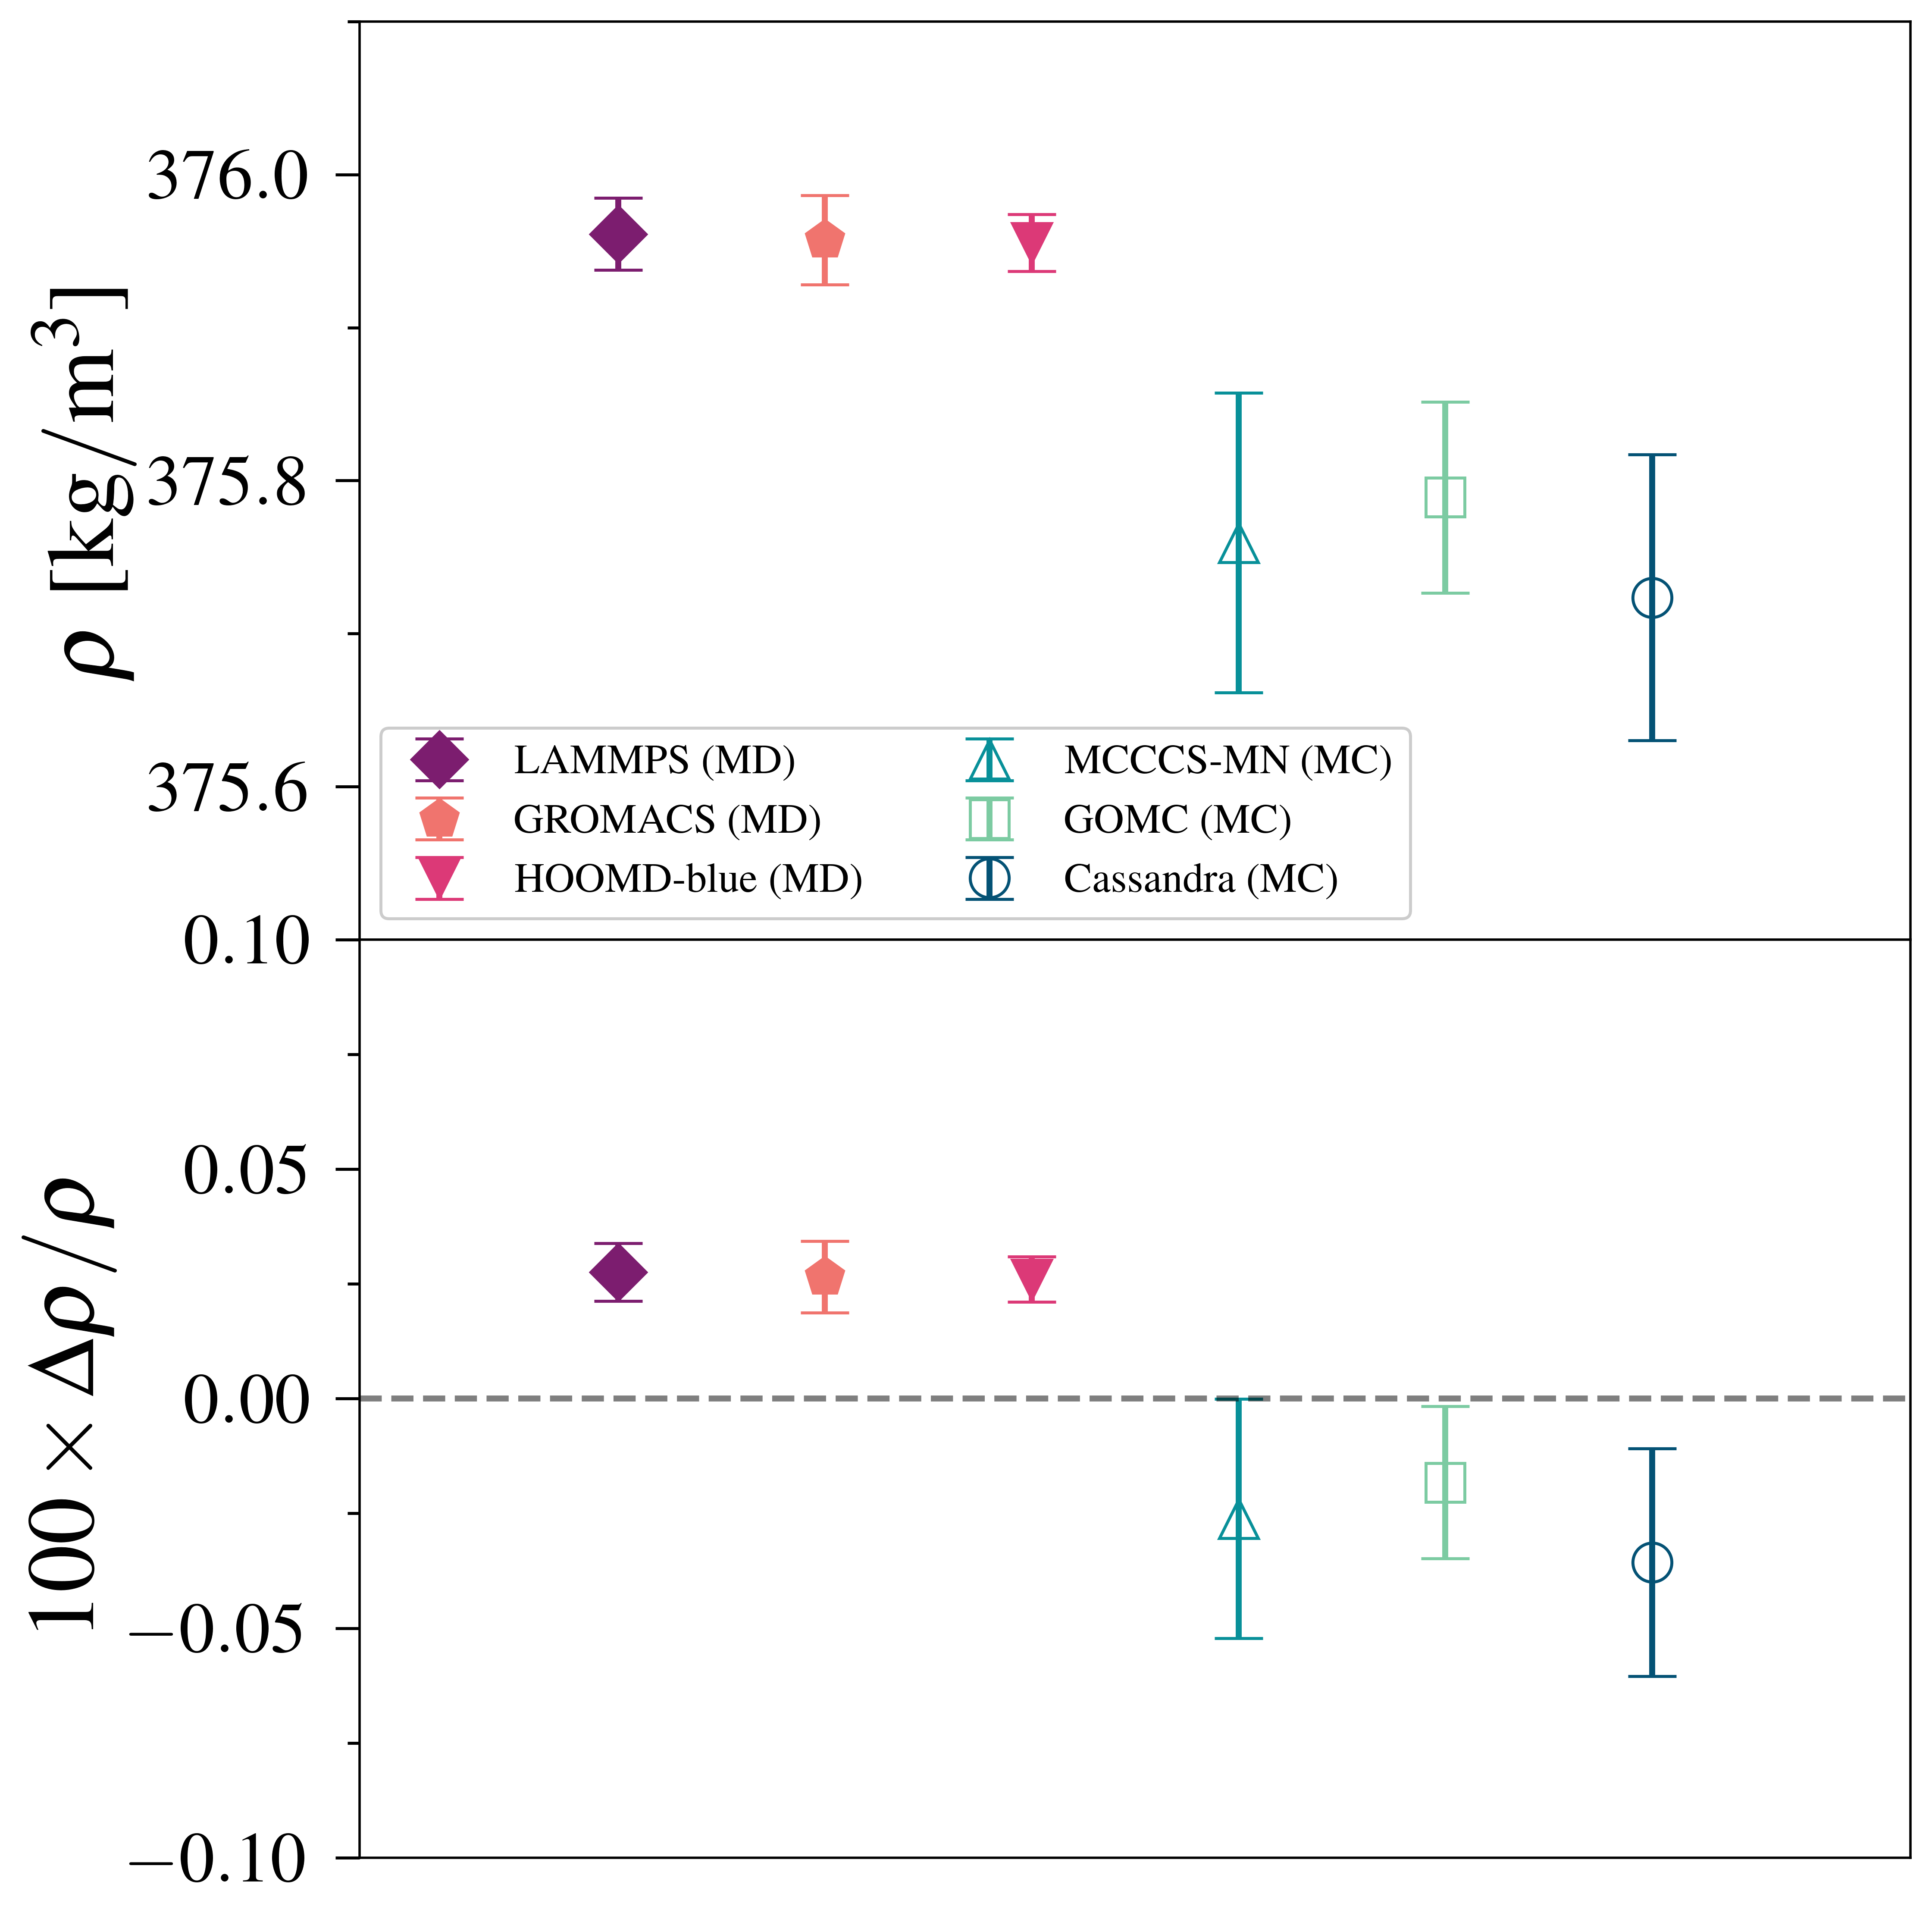

ethanolAA
lammps-VU 815.9397273704785 0.15354750897824798
0.18556191764909238 0.018853406632885105
gromacs 816.7769358122503 0.11792478148531568
0.28835896915608034 0.014479452465436835
hoomd 814.5008873068462 0.05733211979659115
0.008893230674885325 0.007039552610414145
mcccs 812.7309012571694 0.5264676613600513
-0.20843537954579058 0.06464259149975013
gomc 813.1313624791042 0.7529628893234684
-0.15926455086821728 0.09245291979239109
cassandra 813.4909356063542 0.7111560260273305
-0.1151141870660641 0.08731964345979239
lammps-VU 795.459555507352 0.0930662611979893
0.2925833931880172 0.011733916196830816
gromacs 795.6233378115081 0.1932170848857222
0.31323328077083934 0.024361063318335964
hoomd 793.6996657943505 0.0617878897434825
0.07069419142786082 0.007790298126263506
mcccs 791.4208917911246 0.450235404147355
-0.21661662176237234 0.056766269893148535
gomc 791.3484722631563 0.7066619452222777
-0.2257473707712626 0.0890968642985177
cassandra 791.2818525394791 0.4704923443083885
-0.234

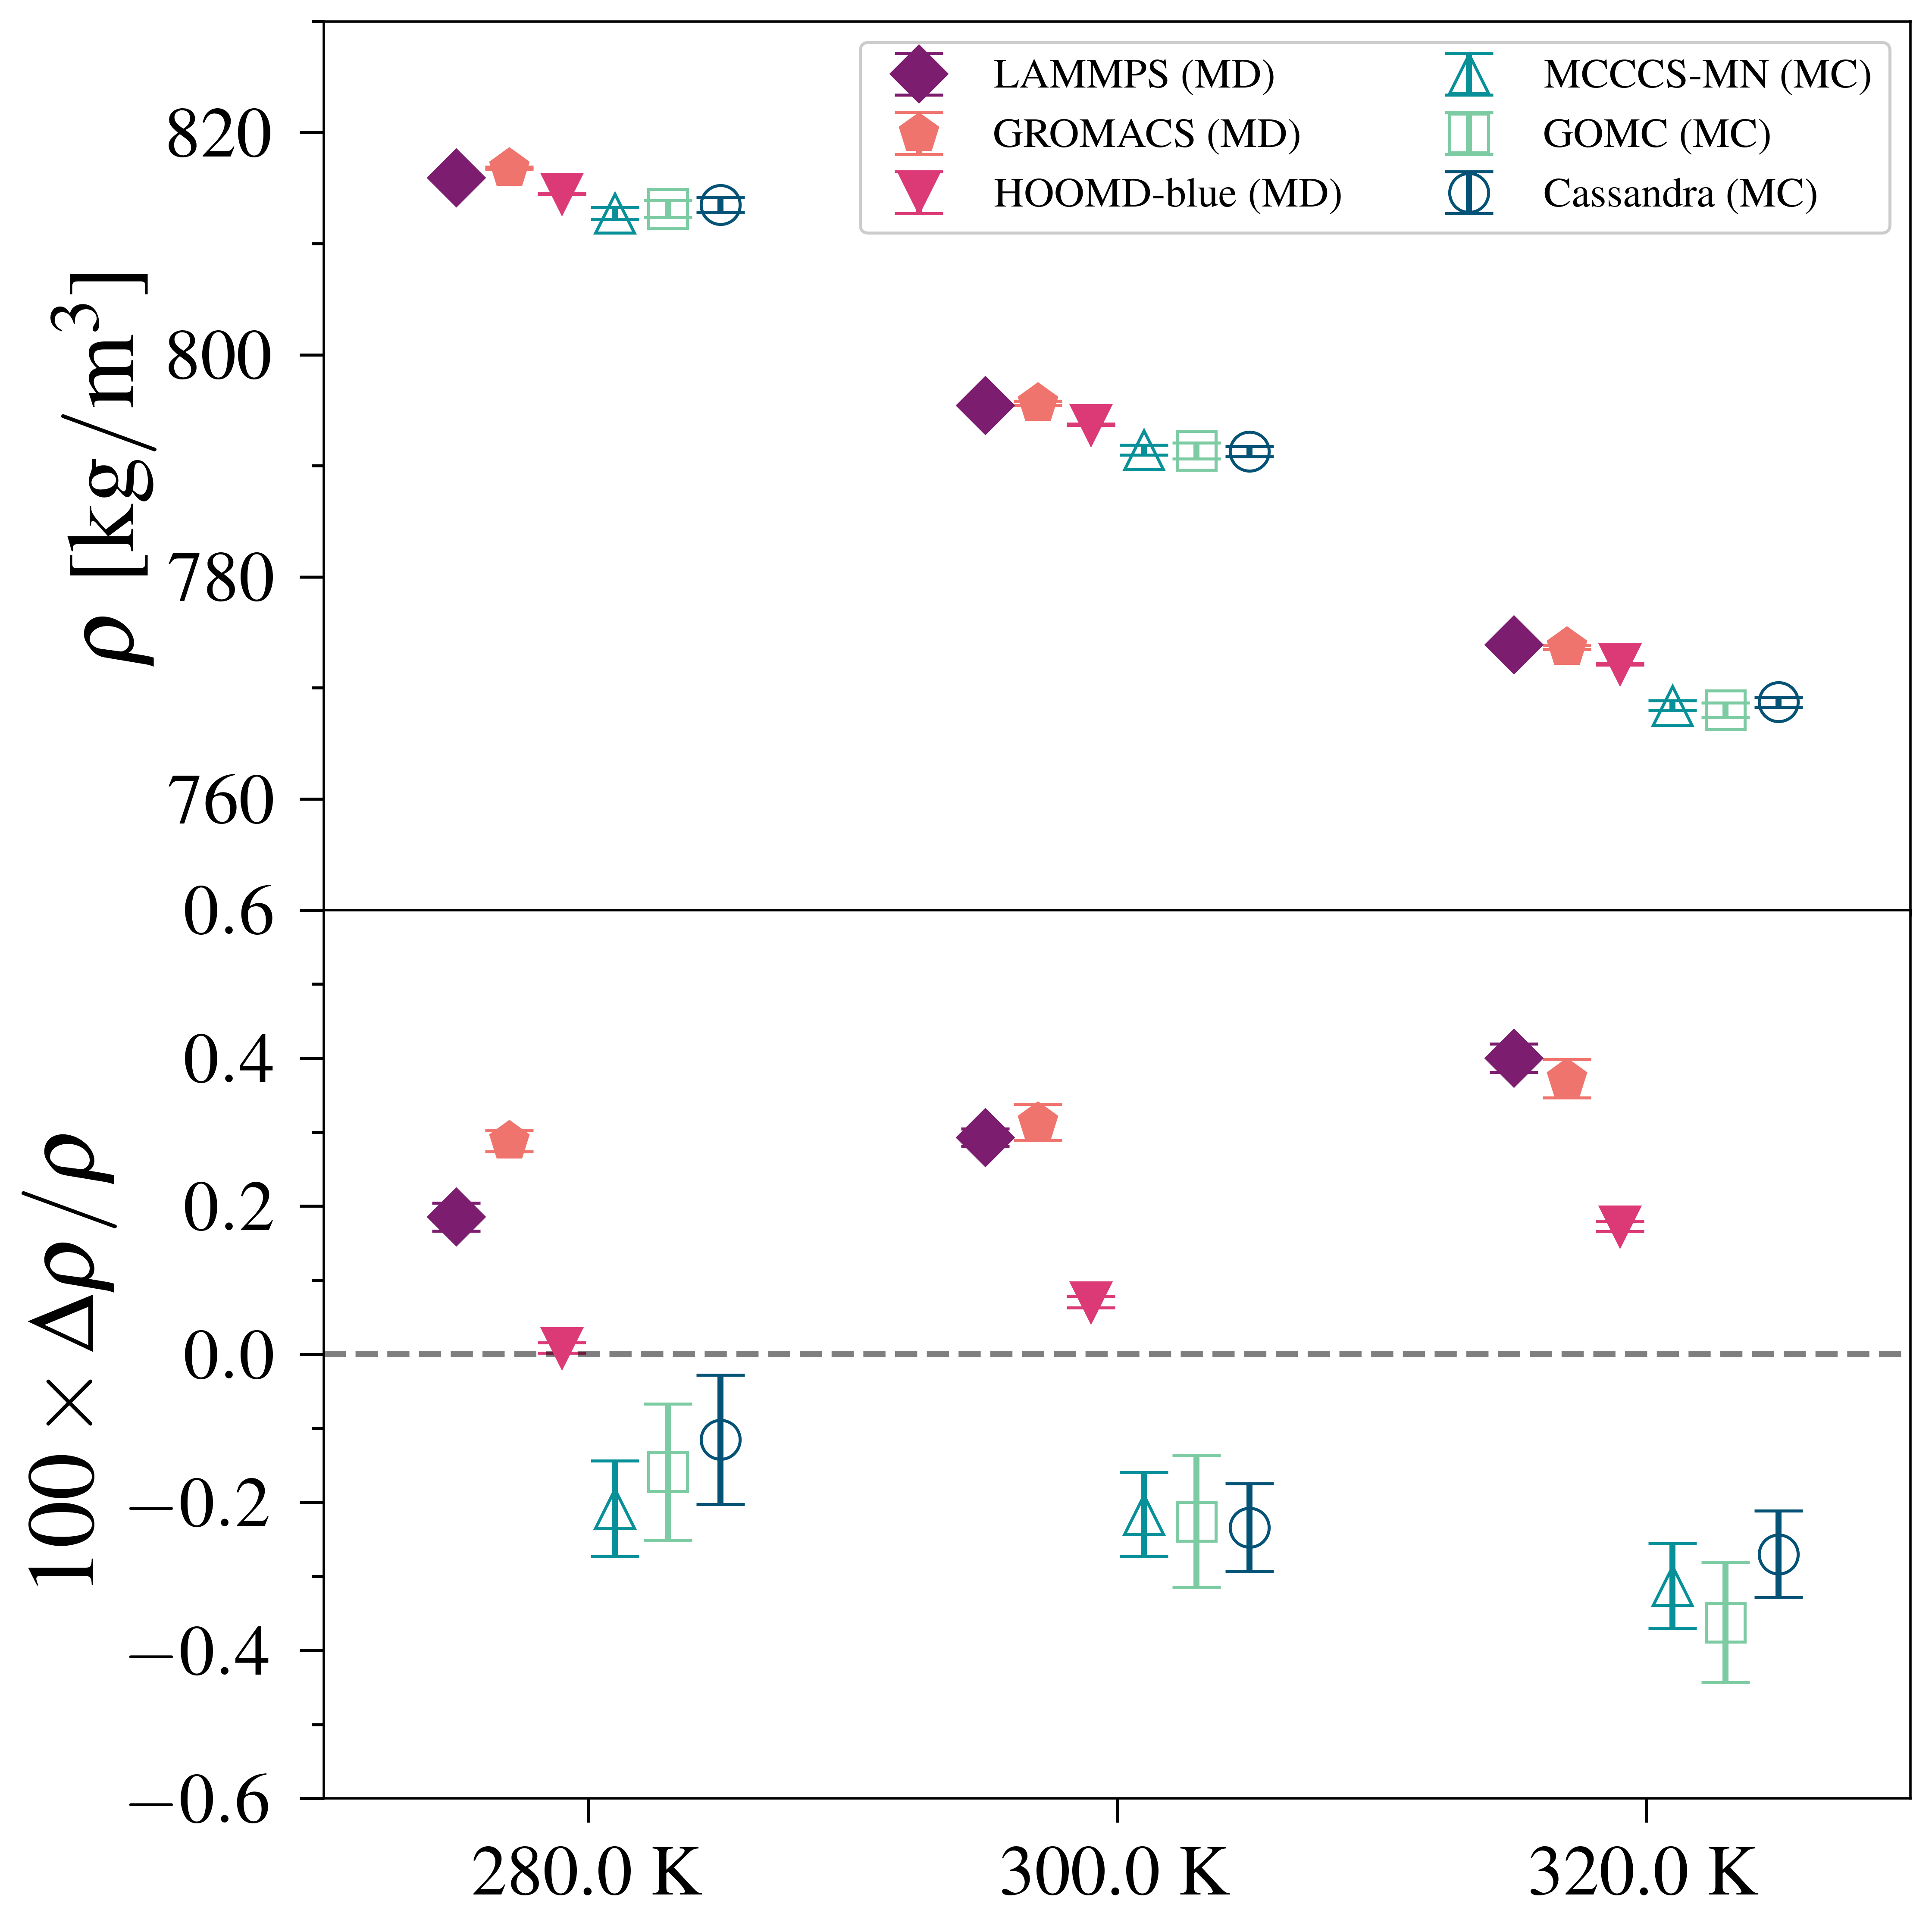

waterSPCE
lammps-VU 1006.8703746677388 0.1028518417047487
0.008367718387087459 0.010215858033479417
gromacs 1006.7314775410092 0.07639957251286823
-0.005428372226449005 0.007588460971369682
hoomd 1006.6162688090135 0.046373144428155995
-0.016871590264917354 0.004606057141922874
mcccs 1007.0531403810822 0.7392696037117813
0.026521098530380083 0.07342866393842565
gomc 1006.8742335552554 0.8782718713157108
0.008751006098644695 0.08723519777036087
cassandra 1006.571282883802 0.8818330331263011
-0.021339860524813632 0.08758891359001217
lammps-VU 998.0337444024184 0.08295618793502428
0.019359815028131402 0.008313571416289462
gromacs 997.8686019548104 0.05382021997197306
0.0028098316426216764 0.005393669279112295
hoomd 997.7835112811019 0.037059448775387256
-0.005717650276986067 0.0037139649459763096
mcccs 997.7080406908347 0.7931282608189607
-0.013281041961618993 0.07948446767781141
gomc 997.8894387415363 0.6359688915775661
0.004898019622854255 0.06373451975408684
cassandra 997.7600488186458

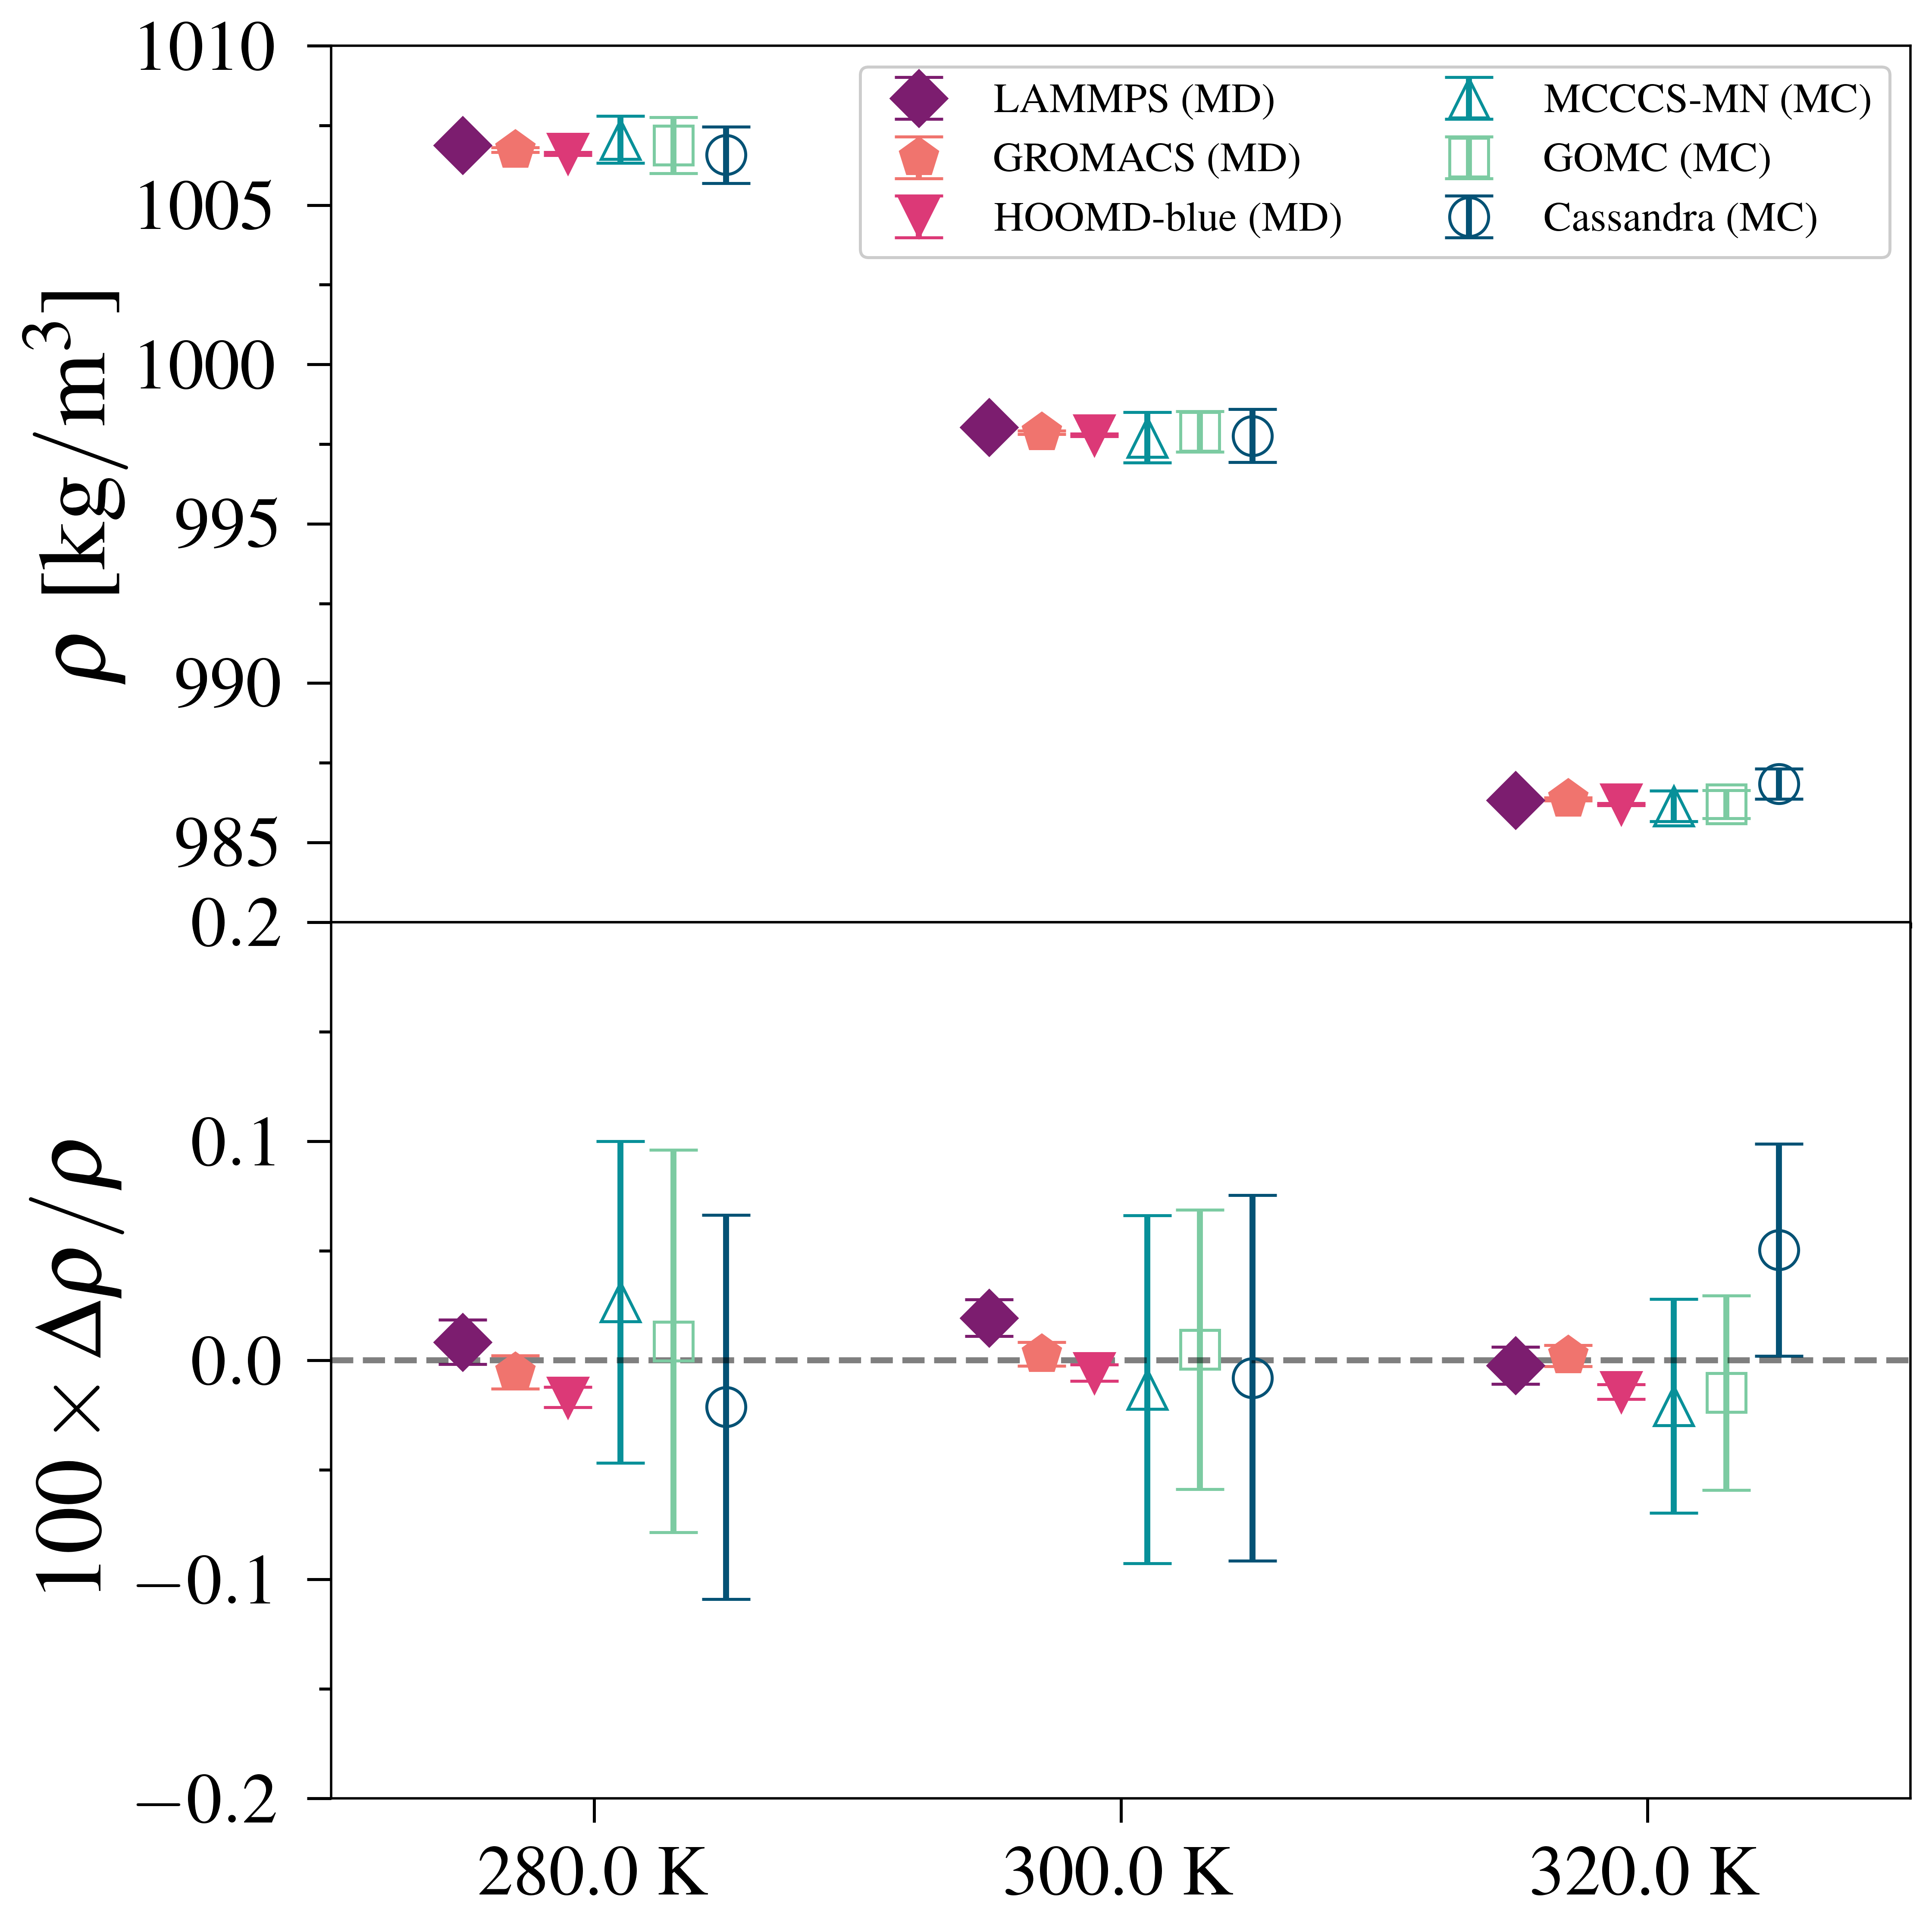

benzeneUA
lammps-VU 697.6658407109692 0.12292614350852053
-0.10470505373071066 0.01760118189228985
hoomd 699.154497647805 0.052681201061860264
0.10844831440248831 0.007543158645742628
mcccs 698.0419139941409 0.5006731027747139
-0.05085699445698898 0.07168888650528632
gomc 698.6877138757968 0.4352795503279922
0.041611872283766144 0.06232550961615482
cassandra 698.4355226084895 0.5180642037492366
0.005501861501428915 0.07417903158608873


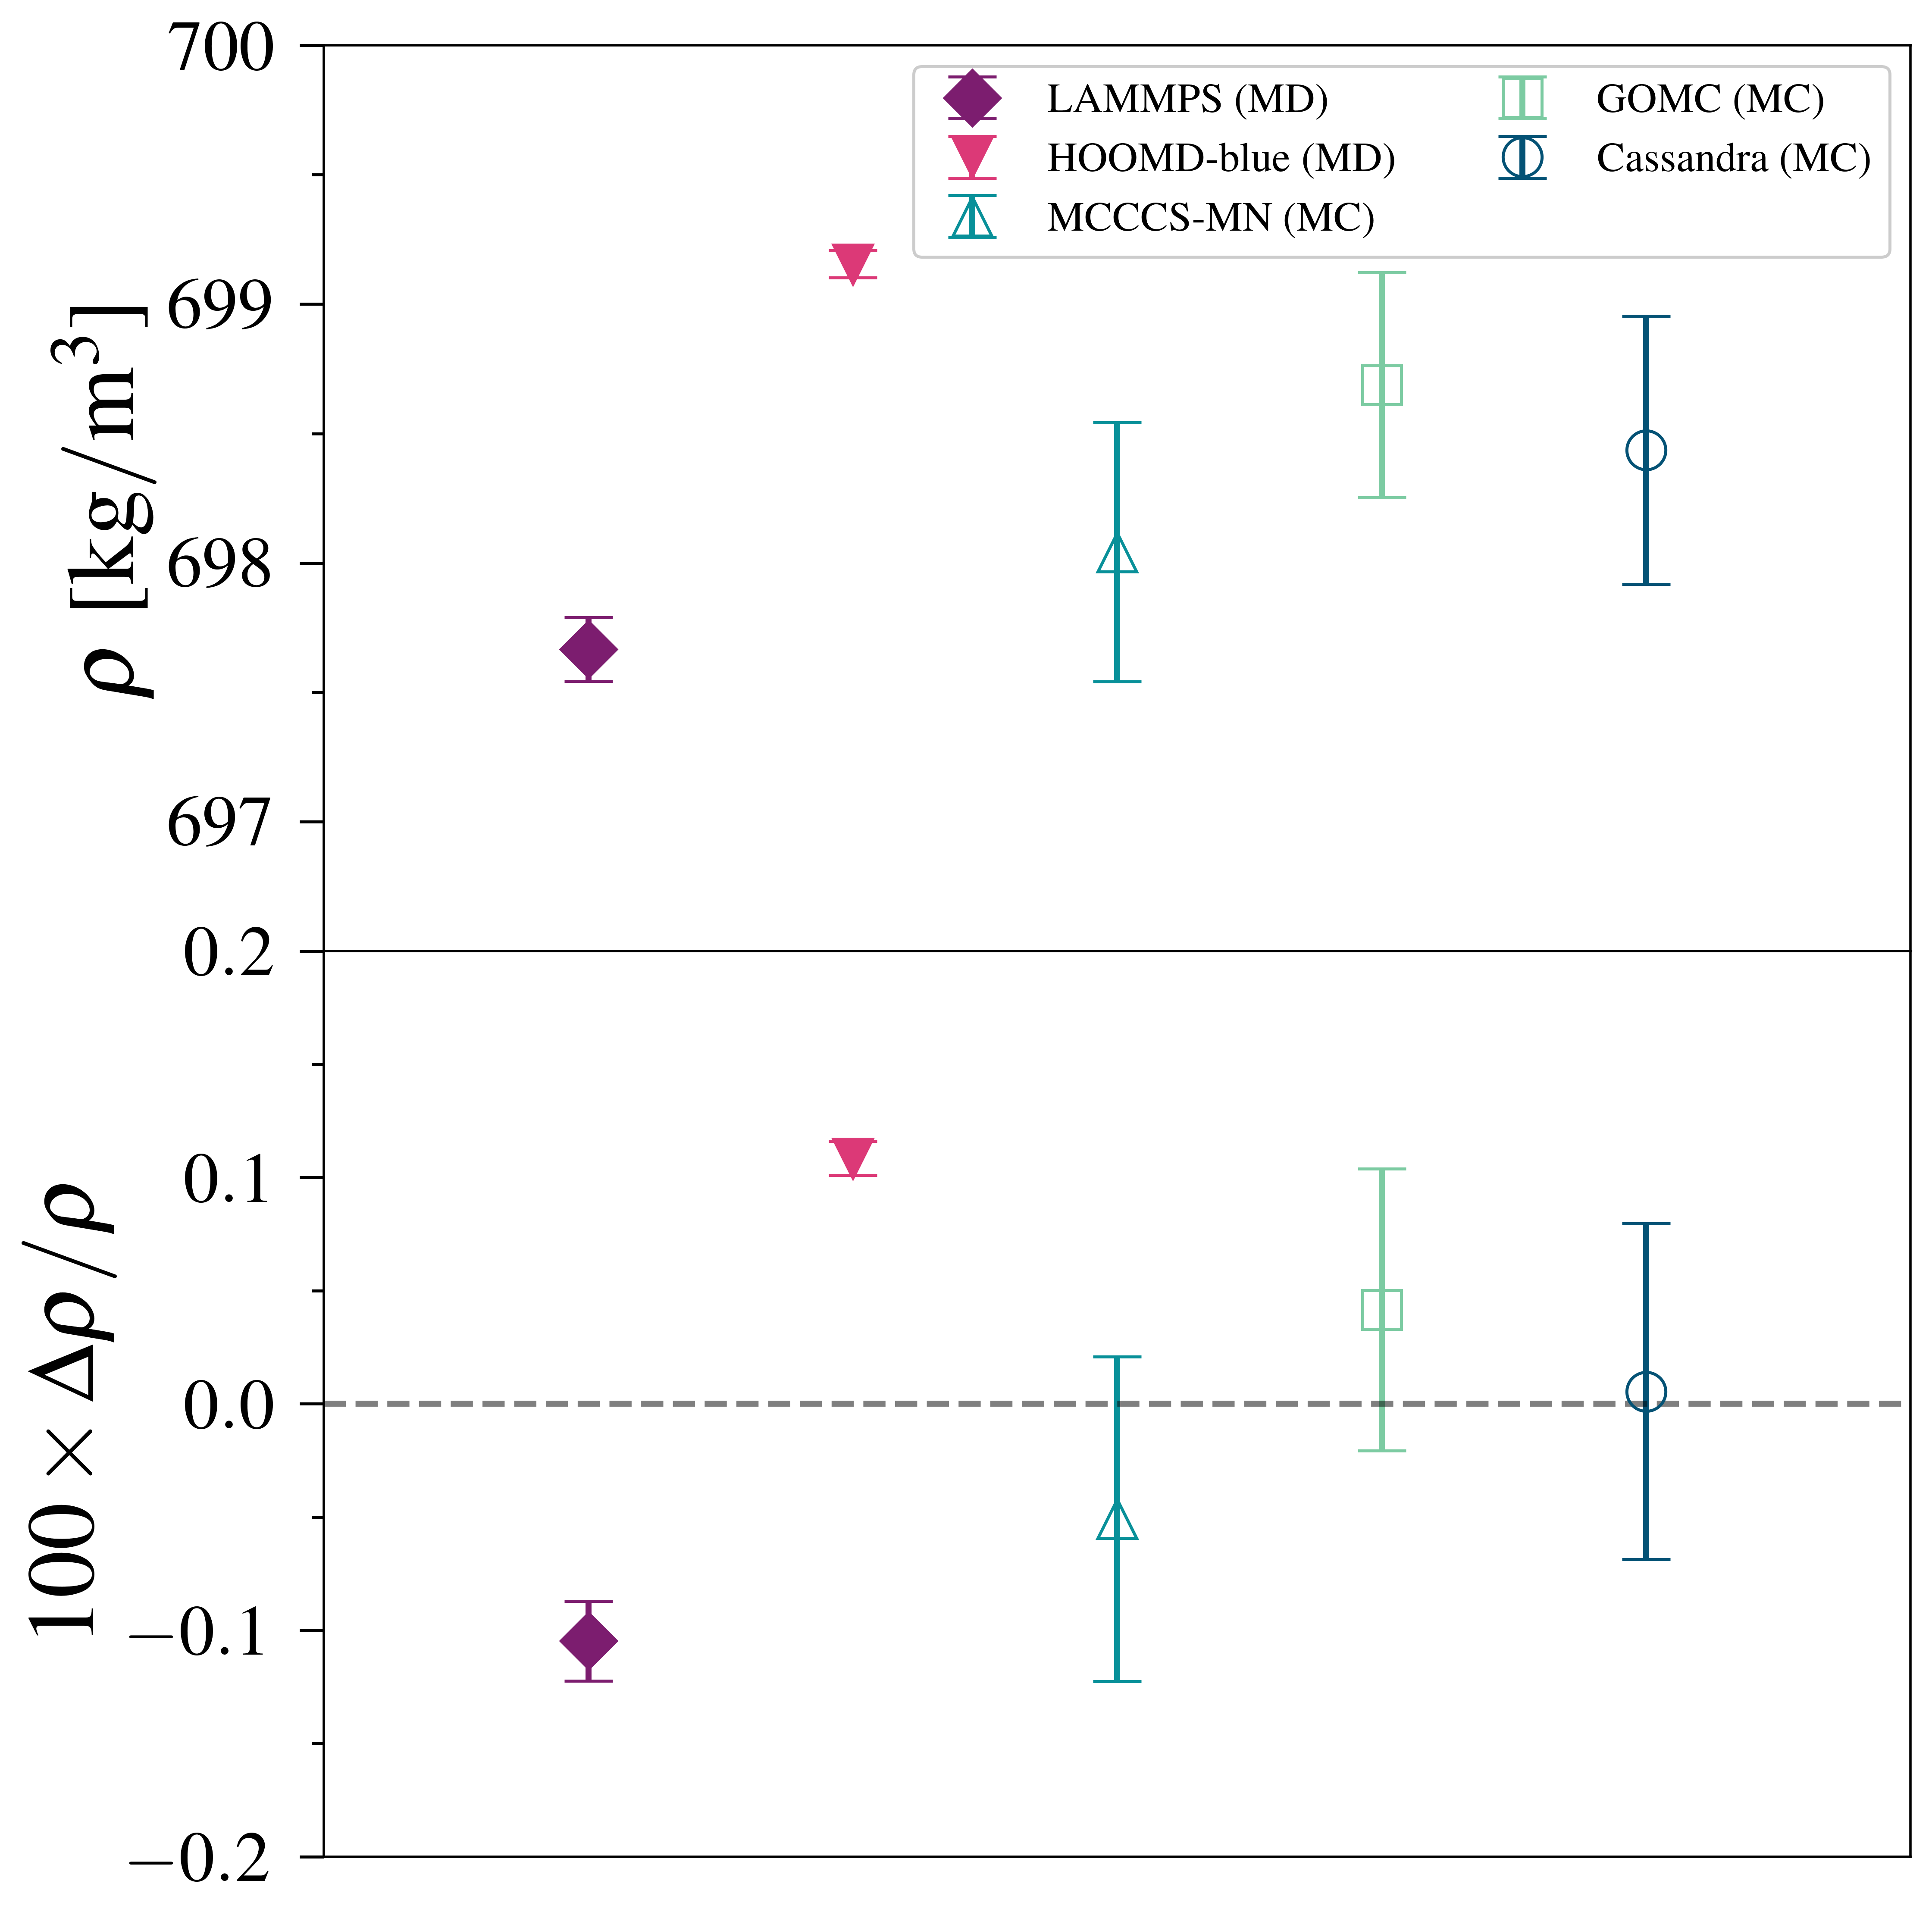

pentaneUA-constrain_bonds
gromacs 541.9106091623472 0.15610415748901807
0.10627123444701934 0.028836868786488164
hoomd 541.6387978239145 0.0734839957584261
0.05605996507954413 0.013574579804139177
mcccs 541.0886453415661 0.18443469360085776
-0.04556881407169068 0.03407032294715303
gomc 540.849320879125 0.27524065367099837
-0.08977883532815113 0.05084476123050204
cassandra 541.189253940625 0.4526816702455077
-0.026983550126637657 0.08362315352066362


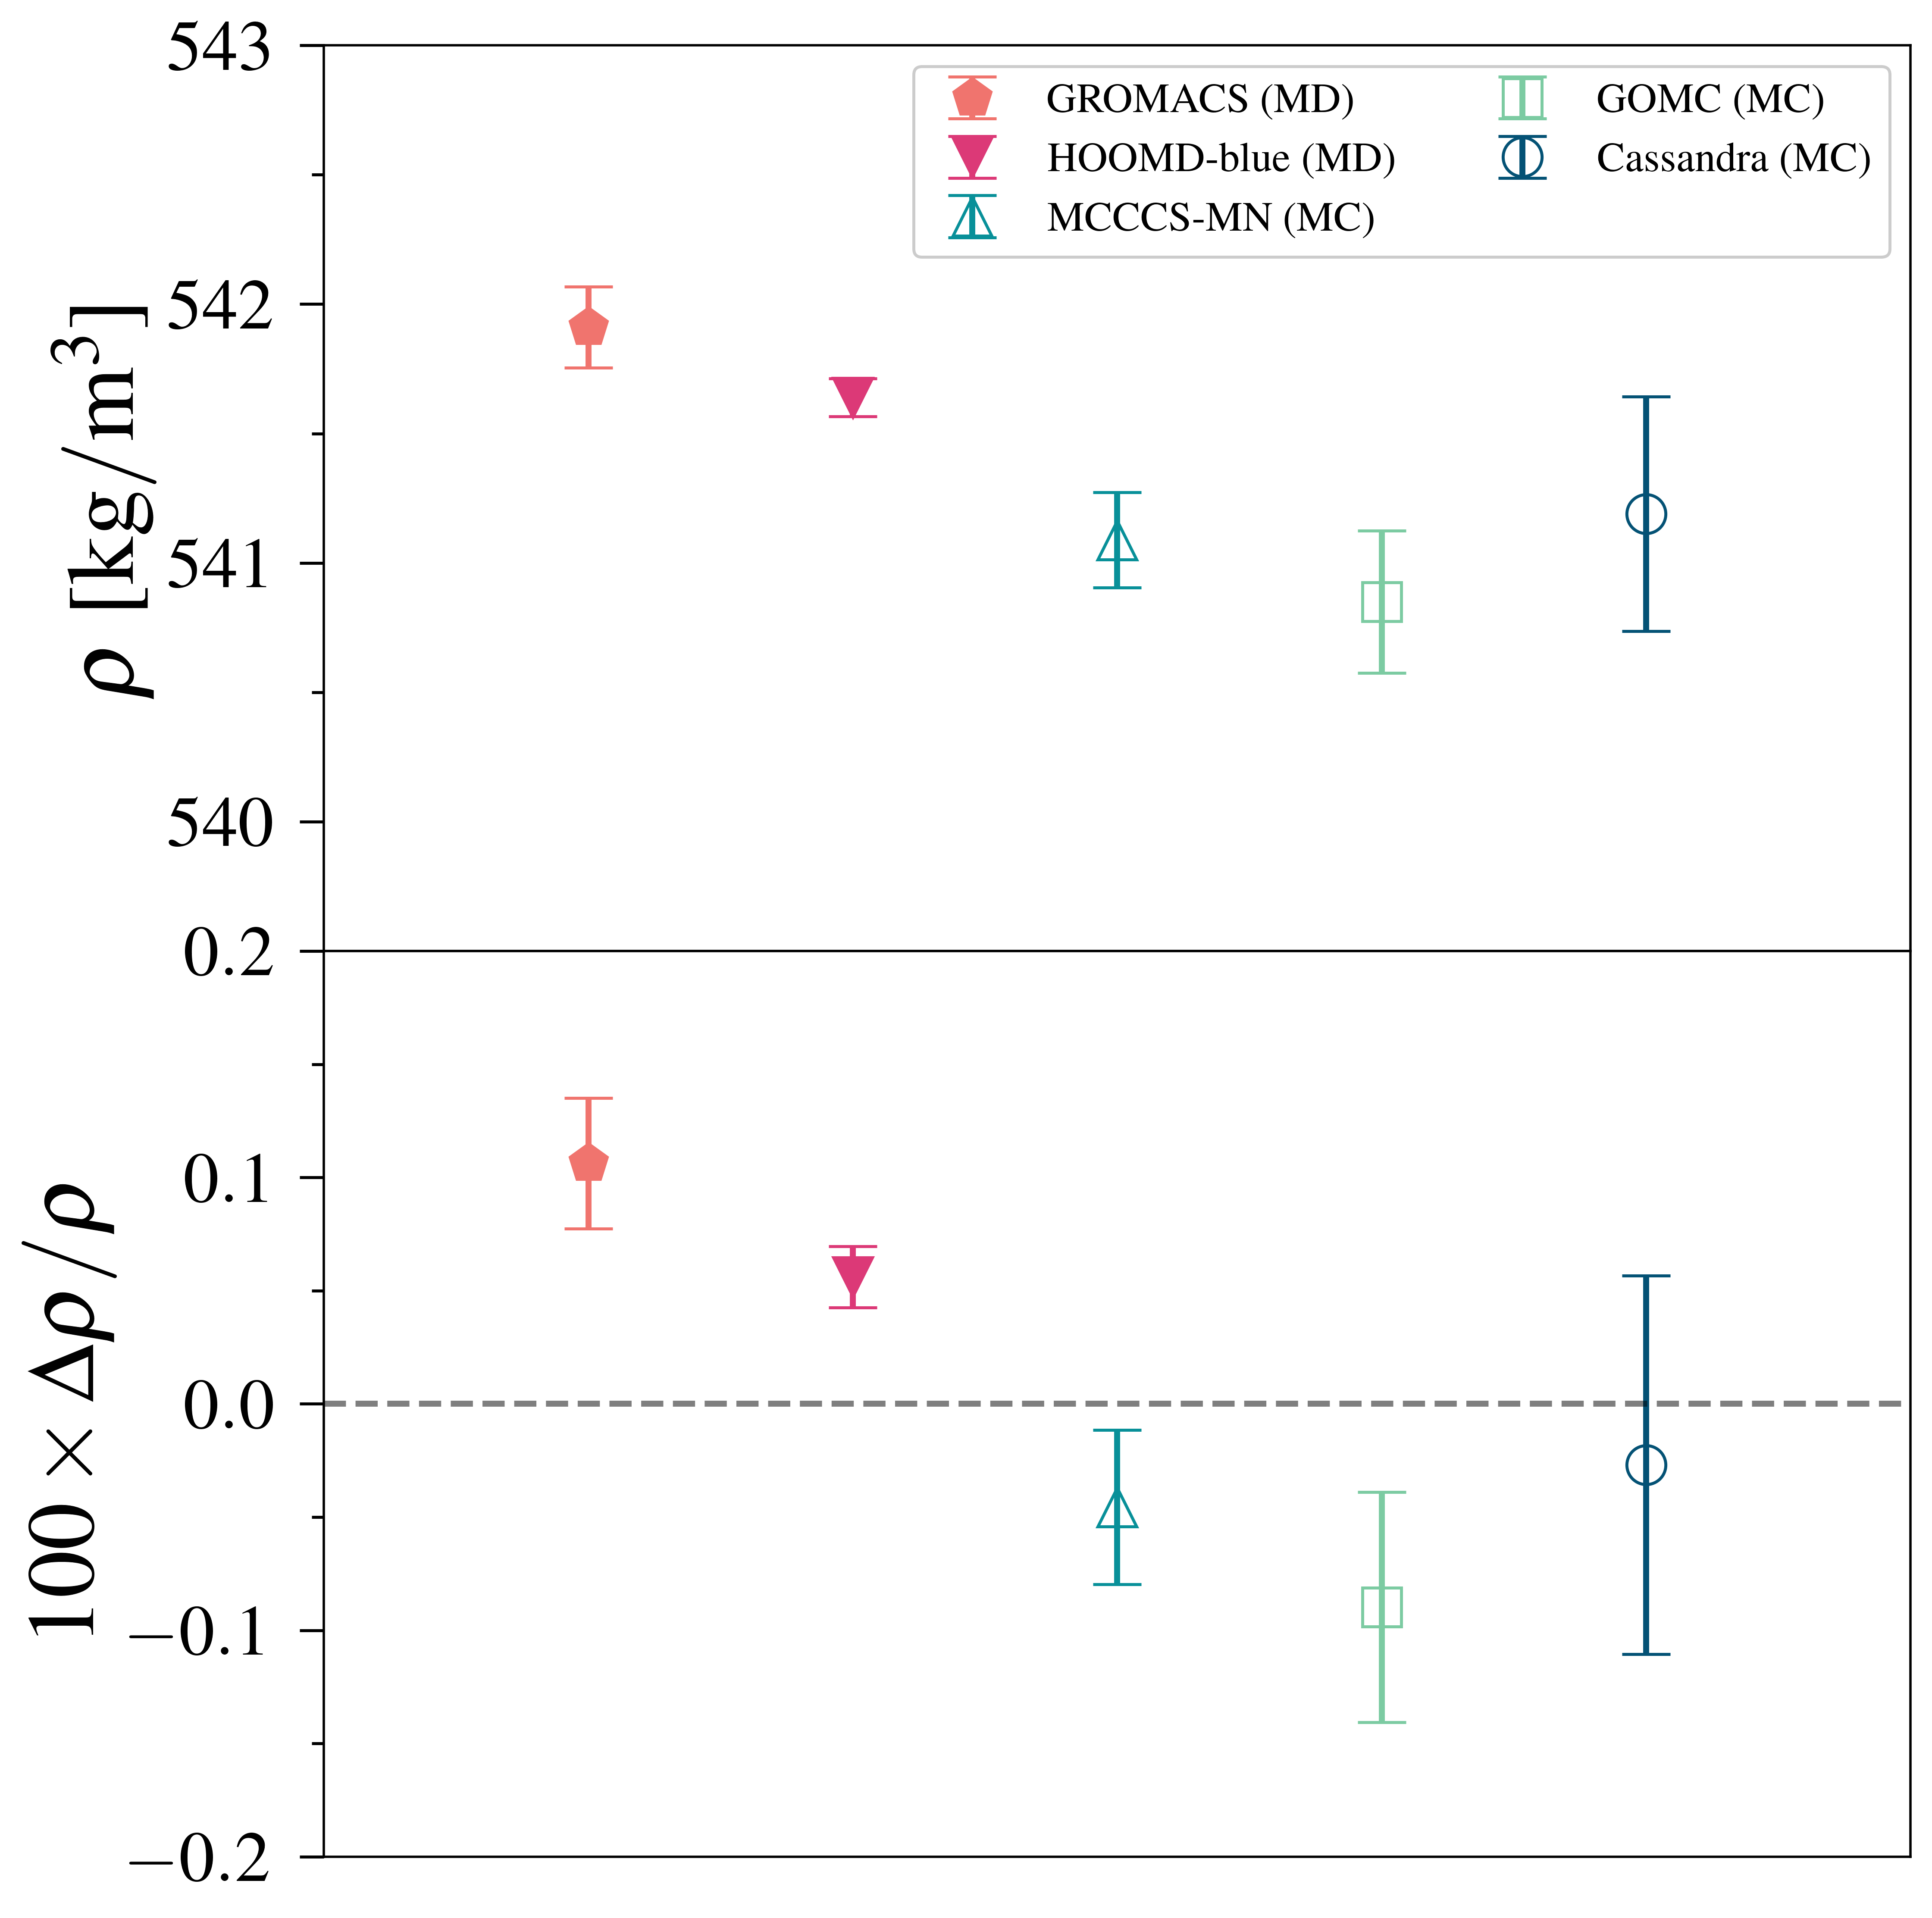

In [12]:
modfigsize = [9, 9]
create_stacked_density_deviation_plots(all_engine_molecule, all_engine_orders, modfigsize)
create_stacked_density_deviation_plots(rigid_benzene, rigid_benzene_orders, modfigsize)
create_stacked_density_deviation_plots(pentane_fixed, pentane_fixed_orders, modfigsize)
#create_stacked_density_deviation_plots(pentane_flexible, pentane_flexible_orders, modfigsize)